### Label curation 

- First Step to initialize

In [3]:
import torch 
from collections import Counter
import random
from datasets import load_dataset
import numpy as np
import math

seed =3
random.seed(seed)
np.random.seed(seed)

dataset_name='all_train'
# model_name="meta-llama/Meta-Llama-3.1-8B-Instruct"
model_name="gpt-4o-mini"
# model_name= "mistralai/Mistral-7B-Instruct-v0.3"

dataset_size = 10000
confidence_prob = 0.5


all_train_dataset = load_dataset('json', data_files =f"../full_dataset.json")

#################################################################################################################################
# label curation reports
# report_path = f"score_curation/results/{model_name}/{dataset_name}/{dataset_name}_report.pt"

report_path = f"results-embedding-model-bge/{model_name}/{dataset_name}/{dataset_name}_report.pt"



reports = torch.load(report_path)

# Part 1 (label-wise): label curation
corrupted_samples = [x[0] for x in reports.detection['label_error']]

cured_samples = []
cured_sample_labels = []
for sample in reports.curation['label_curation']:  # (idx, label, confidence)
    if sample[2] >= confidence_prob:  # confidence prob
        cured_samples.append(sample[0])
        cured_sample_labels.append((int(sample[0]), int(sample[1]), round(sample[2],2)))

print(f"Cured sample size: {len(cured_sample_labels)}")

# Filter out some cured samples from corrupted instances
cured_samples_set = set(cured_samples)
corrupted_samples_total = [x for x in corrupted_samples if x not in cured_samples_set]

print(f"Corrupted samples total: {len(corrupted_samples_total)}")

# Change the original labels to the suggested label
root_path = f"../model_finetune/selected_data/{model_name}/{dataset_name}/"


labels = torch.load(root_path + "output_labels_revised.pt")

print(f"Original Counter(labels): {Counter(labels)}")

count=0
#identify the transition labels
count_labels_5 = []
count_labels_4 = []
count_labels_3 = []
count_labels_2 = []

for sample_label in cured_sample_labels:
    if labels[sample_label[0]] == 5:
        count_labels_5.append(sample_label)
        # continue ## determine whether remain the 5-rated samples

    if labels[sample_label[0]] == 4:
        count_labels_4.append(sample_label)

    if labels[sample_label[0]] == 3:
        count_labels_3.append(sample_label)

    if labels[sample_label[0]] == 2:
        count_labels_2.append(sample_label)

    labels[sample_label[0]] = sample_label[1]
    count+=1

print(f"counting revised label size: {count}")

print(f"Label size: {len(labels)}")
label_counts = Counter(labels)

print(f"Revised Counter(labels): {label_counts}")

# Filter out the low-quality samples
label_wise_filter_out_samples = set(corrupted_samples_total)
print(f"Label-wise filter out samples: {len(label_wise_filter_out_samples)}")

### load the label noise 
# torch.save(labels, root_path + f"output_labels_revised_cured.pt")


Generating train split: 300932 examples [00:04, 71557.25 examples/s] 
/tmp/ipykernel_146787/3176471042.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reports = torch.l

==== Docta: Doctor for your data. Current version: 0.2 ====
Cured sample size: 10510
Corrupted samples total: 112457
Original Counter(labels): Counter({3: 87975, 2: 86132, 4: 59969, 1: 44401, 0: 18626, 5: 3829})
counting revised label size: 10510
Label size: 300932
Revised Counter(labels): Counter({3: 89665, 2: 86085, 4: 61057, 1: 43117, 0: 18503, 5: 2505})
Label-wise filter out samples: 112457


/tmp/ipykernel_146787/3176471042.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(root_path + "output_labels_revised.pt")


In [2]:
len(reports.curation['label_curation']) 

122967

In [3]:
import numpy as np
from collections import Counter

selected_count_labels = count_labels_5

Counter(np.array([[int(a), int(b), float(c)] for a, b, c in selected_count_labels])[:,1])

Counter({np.float64(4.0): 1269,
         np.float64(3.0): 43,
         np.float64(2.0): 7,
         np.float64(1.0): 3,
         np.float64(0.0): 2})

In [4]:
target_low_label = 3
array_data = np.array([[int(a), int(b), float(c)] for a, b, c in selected_count_labels])
low_indices = np.where(array_data[:, 1]== target_low_label)


change_to_low_rated_samples = all_train_dataset['train'].select(low_indices[0])

In [ ]:
set(change_to_low_rated_samples['dataset'])

{'flan_v2'}

## Filetered method: Our data selection method
-  Filtered 5: label-filtered based: all 5 samples  + 4-rated samples select using sorted long-tail score (reverse=True)

In [ ]:
import torch
import random
import numpy as np
from datasets import load_dataset
from collections import Counter

# Set random seed for reproducibility
seed = 3
random.seed(seed)
np.random.seed(seed)

report_path = f"results-embedding-model-bge/{model_name}/{dataset_name}/{dataset_name}_report.pt"
reports = torch.load(report_path)


# Part 2 (feature-wise): Process rare samples based on 'rare_example' detection
rare_samples = reports.detection['rare_example'][:len(reports.detection['rare_example']) // 2]
rare_samples_filtered = np.array(rare_samples)[:, :2]  # Use NumPy for faster operations

print(f"Size of the remaining samples with high quality: {len(rare_samples_filtered)}")

# Assume 'labels' is a Python list; convert it to a NumPy array for efficient indexing
labels = np.array(labels)

# Cache label indices to avoid repeated searches
label_indices_cache = {label: np.where(labels == label)[0] for label in [5, 4, 3, 2, 1]}
print(f"Finished caching labels indices...")

# Initialize list to store selected indices
filtered_indices = []

# Filter and sort samples by label
for target_label in [5, 4, 3, 2, 1]:
    if len(filtered_indices) >= dataset_size:
        break

    # Get indices of current label
    label_indices = label_indices_cache[target_label]
    available_size = dataset_size - len(filtered_indices)

    # Add label indices if enough space, else sort and add top samples
    if available_size > len(label_indices):
        filtered_indices.extend(label_indices.tolist())
    else:
        # Filter and sort samples with the target label by score
        label_samples = rare_samples_filtered[np.isin(rare_samples_filtered[:, 0], label_indices)]
        if len(label_samples) > 0:  # Ensure label_samples is not empty
            sorted_samples = label_samples[label_samples[:, 1].argsort()[::-1]][:available_size]
            filtered_indices.extend(sorted_samples[:, 0].astype(int).tolist())

    print("Size of the filtered dataset:", len(filtered_indices))

# Load the dataset and filter out samples by selected indices
data = load_dataset('json', data_files=root_path + 'full_dataset.json')

# Select and save filtered samples
filtered_dialogs = data['train'].select(filtered_indices)
filtered_dialogs.to_json(root_path + f"filtered-cured-{confidence_prob}_dataset.json")
print(f"Filtered dataset saved to {root_path}filtered-cured-{confidence_prob}_dataset.json")


## Selecting high-long-tail score v.s. low long-tail score

In [3]:
import torch
import random
import numpy as np
from datasets import load_dataset
from collections import Counter

seed = 3
random.seed(seed)
np.random.seed(seed)

dataset_name='all_train'
# model_name="meta-llama/Meta-Llama-3.1-8B-Instruct"
model_name="gpt-4o-mini"
target_labels = [5, 4, 3, 2, 1, 0]
report_path = f"results-embedding-model-bge/{model_name}/{dataset_name}/{dataset_name}_report.pt"
reports = torch.load(report_path)

root_path = f"../model_finetune/selected_data/{model_name}/{dataset_name}/"
labels = torch.load(root_path + "output_labels_revised.pt")


rare_samples = reports.detection['rare_example'][:len(reports.detection['rare_example']) // 2]
rare_samples_filtered = np.array(rare_samples)[:, :2]  

print(f"Size of the remaining samples with high quality: {len(rare_samples_filtered)}")

labels = np.array(labels)

# Cache indices for each label value for faster lookup
label_indices_cache = {label: np.where(labels == label)[0] for label in target_labels}
print(f"Finished caching labels indices...")

# Initialize a dictionary to store filtered indices for each target label
filtered_indices = {}

# Process and sort samples for each target label
for target_label in target_labels:
    # Retrieve indices for the current label from the cache
    label_indices = label_indices_cache[target_label]

    # Filter rare samples to get those that belong to the current label
    label_samples = rare_samples_filtered[np.isin(rare_samples_filtered[:, 0], label_indices)]
    
    if len(label_samples) > 0:  # Ensure label_samples is not empty
        # Sort samples for the current label by score in descending order
        sorted_samples = label_samples[label_samples[:, 1].argsort()[::-1]]
        
        # Store sorted indices in the dictionary for the current target label
        filtered_indices[target_label] = sorted_samples[:, 0].astype(int).tolist()

# Print the sizes for verification (optional)
for label, indices in filtered_indices.items():
    print(f"Label {label}: {len(indices)} samples selected")



/tmp/ipykernel_148486/184828502.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reports = torch.load(report_path)
/tmp/ipykernel_148486/184828502.py:19: FutureWarning: 

Size of the remaining samples with high quality: 300932
Finished caching labels indices...
Label 5: 3829 samples selected
Label 4: 59969 samples selected
Label 3: 87975 samples selected
Label 2: 86132 samples selected
Label 1: 44401 samples selected
Label 0: 18626 samples selected


In [17]:
data = load_dataset('json', data_files='../full_dataset.json')

### choose the target label(score)
target_label = 1
top_k = 5
high_long_tail_examples_indices = filtered_indices[target_label][:top_k]

low_long_tail_examples_indices = filtered_indices[target_label][-top_k:]

high_long_tail_examples = data['train'].select(high_long_tail_examples_indices)
low_long_tail_examples =  data['train'].select(low_long_tail_examples_indices)


In [18]:
high_long_tail_examples['messages'][1]

[{'role': 'user',
  'content': 'Given this paragraph, what is the strongest part of the scapholunate ligament?\nThe scapholunate ligament is an intraarticular ligament binding the scaphoid and lunate bones of the wrist together. It is divided into three areas, dorsal, proximal and palmar, with the dorsal segment being the strongest part. It is the main stabilizer of the scaphoid. In contrast to the scapholunate ligament, the lunotriquetral ligament is more prominent on the palmar side.\n\n'},
 {'role': 'assistant',
  'content': 'Given this text, the dorsal segment is the strongest part of the scapholunate ligament.'}]

In [19]:
low_long_tail_examples['messages'][1]

[{'role': 'user', 'content': 'โรงเรียนราชินีล่างกับราชินีบนต่างกันยังไง'},
 {'role': 'assistant', 'content': 'อยู่กันคนละที่'},
 {'role': 'user', 'content': 'อันไหนอยู่บน อันไหนอยู่ล่าง'},
 {'role': 'assistant', 'content': 'ใช้แผนที่เปรียบเทียบ'}]

## plot the embedding vector in the embedding space.

In [21]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
import random
import numpy as np
from tqdm import tqdm
import os

# Set random seed for reproducibility
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to calculate cosine distance and return KNN indices (excluding the sample itself)
def cosDistance(sample_embedding, all_embeddings, k_near=10):
    sample_embedding = sample_embedding.to(device)
    all_embeddings = all_embeddings.to(device)

    # Compute cosine similarity and convert to cosine distance
    similarity_vector = torch.matmul(all_embeddings, sample_embedding)
    distance_vector = 1.0 - similarity_vector

    # Get top-k nearest samples, including self at index 0
    distance_vector, topk_indices = torch.topk(distance_vector, k=k_near+1, dim=0, largest=False)

    # Exclude the sample itself from KNN results
    if topk_indices[0] == torch.arange(all_embeddings.size(0))[0]:
        topk_indices = topk_indices[1:]
        distance_vector = distance_vector[1:]

    return distance_vector, topk_indices

# Mean pooling function to obtain sentence embeddings
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Process dialog messages to convert into a text format
def process_dialog(dialog):
    conversation = ""
    for message in dialog['messages']:
        conversation += f"### {message['role']}: {message['content']}\n"
    return {"features": conversation}

# Generate embeddings for text
def embed_text(batch):
    encoded_inputs = tokenizer(batch['features'], padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        model_outputs = model(**encoded_inputs)
    sentence_embeddings = mean_pooling(model_outputs, encoded_inputs['attention_mask'])
    embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    
    batch['embeddings'] = embeddings.cpu().numpy().tolist()
    return batch

##############################################################################################################################

# Set dataset parameters
k_near = 10
dataset_name = "all_train"
dataset_size = 1000

# Load or generate embeddings if they don't already exist
if not os.path.exists(f"{dataset_name}_embeddings.parquet"):
    data = load_dataset('json', data_files=f"../full_dataset.json")
    data['train'] = data['train'].map(process_dialog, batched=False)

    embedding_model_name = "BAAI/bge-large-en-v1.5"
    tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
    model = AutoModel.from_pretrained(embedding_model_name).to(device)
    model = torch.nn.DataParallel(model)

    data['train'] = data['train'].map(embed_text, batched=True, batch_size=2048)
    data['train'].to_parquet(f'{dataset_name}_embeddings.parquet')
    print(f"Embeddings saved to {dataset_name}_embeddings.parquet")

#########################################################################################################################

# Define label and quality indices
label_priority = [5, 4, 3, 2, 1]

# High-quality sample indices
label_indices = high_long_tail_examples_indices  # Replace with your actual label indices

# Load generated embeddings dataset
embedding_dataset = load_dataset('parquet', data_files=f'{dataset_name}_embeddings.parquet')['train']

# Get all embeddings data
all_embeddings = torch.tensor(embedding_dataset['embeddings']).to(device)

# Select high-quality samples and record KNN indices
high_low_knn_indices = {}

for label in ['high', 'low']:
    knn_indices = []

    # Select subset of samples based on quality
    if label == 'high':
        embedding_subset = embedding_dataset.select(high_long_tail_examples_indices)
    else:
        embedding_subset = embedding_dataset.select(low_long_tail_examples_indices)

    for sample_idx, sample in enumerate(tqdm(embedding_subset, desc=f"Processing high-quality samples (label={label})")):
        sample_embedding = torch.tensor(sample['embeddings']).to(device)

        # Calculate cosine distance for the sample and retrieve KNN indices
        _, topk_indices = cosDistance(sample_embedding, all_embeddings, k_near=k_near)
        knn_indices.append(topk_indices.cpu().numpy().tolist())

    high_low_knn_indices[label] = knn_indices



Using device: cuda


Creating parquet from Arrow format: 100%|██████████| 301/301 [00:25<00:00, 11.81ba/s]


Embeddings saved to all_train_embeddings.parquet


Generating train split: 300932 examples [00:42, 7069.10 examples/s] 
Processing high-quality samples (label=low): 100%|██████████| 5/5 [00:00<00:00, 101.19it/s]


In [42]:
dataset = load_dataset('json', data_files=f"../full_dataset.json")['train']

targe_example = 0
diverse_type = 'low' ## low
knn_examples = dataset.select(high_low_knn_indices[diverse_type][targe_example])

for knn_idx in [0,1,2]: ## 2-NN clusterability 0 means the original example 
    print("################")
    print(knn_examples[knn_idx])

################
{'dataset': 'flan_v2', 'id': 'flan_v2_87910', 'messages': [{'role': 'user', 'content': 'In this task, you are given commands (in terms of logical operations) and natural interpretation of the given command to select relevant rows from the given table. Your job is to generate a label "yes" if the interpretation is appropriate for the command, otherwise generate label "no". \n Here are the definitions of logical operators: \n 1. count: returns the number of rows in the view. \n 2. only: returns whether there is exactly one row in the view. \n 3. hop: returns the value under the header column of the row. \n 4. and: returns the boolean operation result of two arguments. \n 5. max/min/avg/sum: returns the max/min/average/sum of the values under the header column. \n 6. nth_max/nth_min: returns the n-th max/n-th min of the values under the header column. \n 7. argmax/argmin: returns the row with the max/min value in header column. \n 8. nth_argmax/nth_argmin: returns the row

In [37]:
high_long_tail_examples[1]

{'dataset': 'stanford_alpaca',
 'id': 'stanford_alpaca_37309',
 'messages': [{'role': 'user',
   'content': 'Task: Given the following song lyrics, provide a title for the song. Output "title: <title>"\nInput: Verse 1\nAnd I dream, of your love, sweet and tender\nIt sounds, like a song, of an angel\nComing down, from the sky, up above\nEvery night, I hope you\'re in my dreams\n\nChorus 1\nBaby hold my heart, and never let go\nBe my everything just like you know\n\nVerse 2\nThe feelings that I have, in my heart\nCan\'t be broken by the two of us apart\n\nChorus 2\nAlways be with me, it\'s what I pray\nSinging all my songs, love and stay\nOutput:'},
  {'role': 'assistant',
   'content': 'title: Sweet Tender Angel (Love and Stay)'}]}

In [27]:
high_long_tail_examples_indices

[243545, 239372, 97859, 238357, 246317]

## PCA

In [53]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from datasets import load_dataset

# Load the generated embeddings dataset
dataset_name = "all_train"  # Replace with your dataset name
embedding_dataset = load_dataset('parquet', data_files=f'{dataset_name}_embeddings.parquet')['train']

# Assume 'labels' is already defined and contains label information for each sample
rate_5_indices = [i for i, label in enumerate(labels) if label == 5]

# Extract embeddings of samples with label 5
pca_embeddings = [embedding_dataset[i]['embeddings'] for i in rate_5_indices]

# Step 1: Train the PCA model on the entire dataset

# Standardize all embeddings for consistency
scaler = StandardScaler()
all_embeddings = np.array(embedding_dataset['embeddings'])  # Convert embeddings to NumPy array
all_embeddings = scaler.fit_transform(all_embeddings)  # Normalize embeddings

# Fit a PCA model on the standardized embeddings
pca = PCA(n_components=2)
pca.fit(all_embeddings)  # Train PCA on the entire dataset


PCA(n_components=2)

### PCA Visualization of All Embeddings

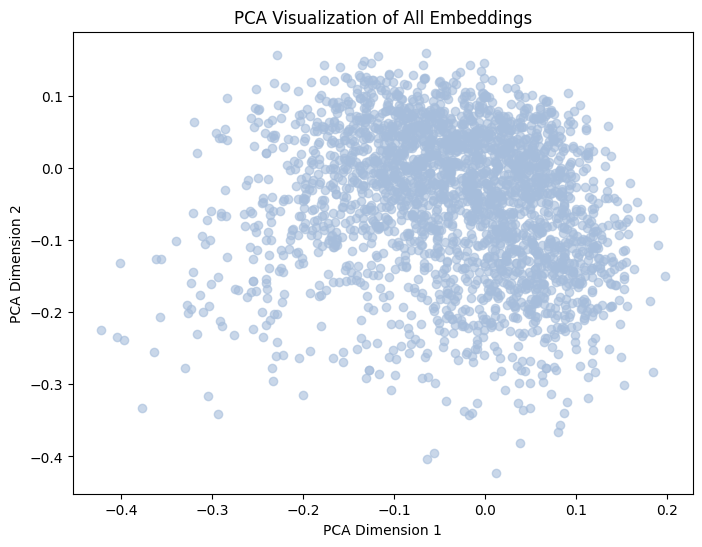

In [60]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize and apply PCA to reduce embeddings to 2D space
scaler = StandardScaler()
all_embeddings = np.array(pca_embeddings)  # Convert embeddings to a NumPy array if not already
all_embeddings = scaler.fit_transform(all_embeddings)  # Standardize embeddings

# Use the previously trained PCA model to transform the embeddings
embeddings_2d = pca.transform(all_embeddings)

# Plot the 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, color='#a6bddb')  # Adjust color and transparency

# Set title and labels for the plot
plt.title("PCA Visualization of All Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")

# Show the plot
plt.show()


## PCA Visualization of Embedding Space 

- two example comparison

Number of KNN indices for high: 11
Number of KNN indices for low: 11


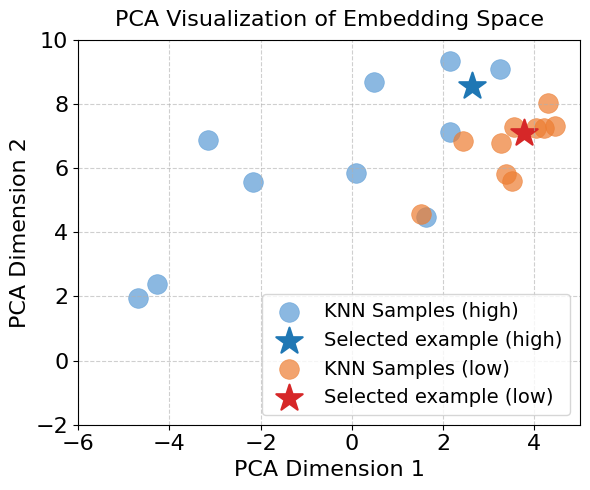

In [109]:
# Create a figure with specified size
fig, ax = plt.subplots(figsize=(6, 5)) 

# Set axis limits based on data range
x_lim = (-6, 5)  # Adjust as needed
y_lim = (-2, 10)  # Adjust as needed

# Define colors for high and low rating samples
colors = {
    'high_knn': '#5A9BD5',        # Light blue for high KNN samples
    'high_selected': '#1F77B4',   # Dark blue for high selected sample
    'low_knn': '#ED7D31',         # Light orange for low KNN samples
    'low_selected': '#D62728',    # Dark orange for low selected sample
}

# Loop through both high and low labels to plot them separately
for label in ['high', 'low']:
    knn_indices = high_low_knn_indices[label]

    # Choose an example index for visualization (can be adjusted)
    if label == 'high':
        example_idx = 0  # Replace with specific sample index if needed
        example_org_idx = high_long_tail_examples_indices[example_idx]
        knn_color = colors['high_knn']
        selected_color = colors['high_selected']
    else:
        example_idx = 0
        example_org_idx = low_long_tail_examples_indices[example_idx]
        knn_color = colors['low_knn']
        selected_color = colors['low_selected']

    knn_idxs = knn_indices[example_idx]  # Get KNN indices for the sample
    print(f"Number of KNN indices for {label}: {len(knn_idxs)}")

    # Extract embeddings for the selected example and its KNN samples
    example_embedding = embedding_dataset[example_org_idx]['embeddings']
    knn_embeddings = [embedding_dataset[idx]['embeddings'] for idx in knn_idxs]

    # Combine example and KNN embeddings into a single matrix, then scale
    all_knn_embeddings = np.vstack(knn_embeddings)
    all_knn_embeddings = scaler.transform(all_knn_embeddings)  # Standardize using predefined scaler

    # Transform embeddings using a trained PCA model
    embeddings_2d_knn = pca.transform(all_knn_embeddings)

    # Plot KNN samples as scatter plot with designated color
    ax.scatter(embeddings_2d_knn[1:, 0], embeddings_2d_knn[1:, 1], color=knn_color, 
               label=f'KNN Samples ({label})', alpha=0.7, s=200, linewidth=0.5)

    # Plot the selected example as a larger star marker
    ax.scatter(embeddings_2d_knn[0, 0], embeddings_2d_knn[0, 1], color=selected_color, 
               label=f'Selected example ({label})', marker='*', s=400, linewidth=1.5)

# Set axis limits for consistency across plots
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.tick_params(axis='both', which='major', labelsize=16)  # Major ticks
ax.tick_params(axis='both', which='minor', labelsize=16)  # Minor ticks

# Add grid lines for easier visual alignment
ax.grid(True, linestyle='--', alpha=0.6)

# Set title and labels for clarity
ax.set_title("PCA Visualization of Embedding Space", fontsize=16, pad=10)
ax.set_xlabel("PCA Dimension 1", fontsize=16)
ax.set_ylabel("PCA Dimension 2", fontsize=16)

# Configure legend
ax.legend(loc='lower right', fontsize=14, frameon=True)

# Adjust subplot parameters to prevent overlap
plt.tight_layout()
plt.show()
